# Utah COVID-19 Modified SIR Model

The SIR model (susceptible, infected, recovered) is one way to predict the infection and recovery rates for a disease that is readily communicable in a large population. In this implementation, a portion of the infected will go to the hospital (H) and some in the hospital will die (D) and some will recover (R). The total number of people is constant S+I+R+H+D = N. Clint Guymon April 15, 2020<br> 
\begin{align}
S\longrightarrow & I \longrightarrow R\\
& I \longrightarrow H \longrightarrow D\\
& H\longrightarrow R\\
\end{align}

## Summary and Conclusions

***Conclusion:*** Social distancing and voluntary quantine efforts with non-essential businesses closed should continue until May 1. Afterwhich, people who are sick should be quarantined and social distancing practices should continue but all businesses should reopen. We should do our best to develop a vaccine as soon as possible.

The below code and analysis highlights five scenarios:
- Without social distancing and voluntary quarantine efforts, the majority of Utah's population are infected within 30 days and 4% eventually die (>100,000).
- With the current level of social distancing and closing of businesses, the economic price is high but to date, it's estimated that 3800 lives have been saved.
- Opening businesses on May 1 with continued voluntary social distancing and quarantine efforts results in approximately half the population being infected over the next two months+ and 4% of those infected die (>50,000). 40,000 lives saved over no quantine efforts.
- Scenario 4 is opening business and then closing them if hospitals near capacity. This results in slightly less deaths than the previous scenario but is likely viewed unfavorably to start and then stop the economy again.
- Scenario 5 is the same as Scenario 3 where instead of opening businesses on May 1 the quarantine efforts are continued until June 1. The difference is unfortunately little as the number of deaths is reduced by only 1%.

Unfortunately, none of those options are attractive. Keeping businesses closed beyond May 1st does not make any sense in my opinion.

Details of each of the above scenarios are below, following the initial code setup. The RO value is essentially the number of people that an infected person then infects. Based on the limited initial data from the last 4 weeks, the RO value has gone down from approximately 3 to 1 or so.  If the businesses open up (with voluntary social distancing and continued quanantine efforts) its estimated that that value would increase to 1.5. These values as well as estimated values for the rates of transfer between the groups were used as defined below.

Data for the existing infections, hospitalizations, and deaths are from the Utah government at https://coronavirus.utah.gov/case-counts/. Note that the below estimates are very rough as there are so many unknowns regarding the behavior of the virus with respect to infection rates and other critcal variables. For example, in Iceland, it has been reported that approximately 50% of people that are infected have no symptoms and that the current testing results in up to a 30% false negative rate (people have the disease but are told they don't).

## Necessary functions to determine each group as a function of time

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#first and second derivatives
class derivatives():
    def dS(var):
        return -var['beta']*var['S'][-1]*var['I'][-1]/var['N']
    def dI(var):
        return var['beta']*var['S'][-1]*var['I'][-1]/var['N']-var['gamma_h']*var['I'][-1]-var['gamma_r']*var['I'][-1]
    def dH(var):
        return var['gamma_h']*var['I'][-1]-var['delta_d']*var['H'][-1]-var['delta_r']*var['H'][-1]
    def dR(var):
        return var['gamma_r']*var['I'][-1]+var['delta_r']*var['H'][-1]
    def dD(var):
        return var['delta_d']*var['H'][-1]
    def d2S(var):
        return -var['beta']*var['S'][-1]/var['N']*derivatives.dI(var)-var['beta']*var['I'][-1]/var['N']*derivatives.dS(var)
    def d2I(var):
        return -derivatives.d2S(var)-var['gamma_h']*derivatives.dI(var)-var['gamma_r']*derivatives.dI(var)
    def d2H(var):
        return var['gamma_h']*derivatives.dI(var)-var['delta_d']*derivatives.dH(var)-var['delta_r']*derivatives.dH(var)
    def d2R(var):
        return var['gamma_r']*derivatives.dI(var) + var['delta_r']*derivatives.dH(var)
    def d2D(var):
        return var['delta_d']*derivatives.dH(var)

In [3]:
#Truncated Taylor series used to integrate and determine the values which is not the most efficient method but 
# provided the time step is sufficiently small, which it is, the outcomes are accurate
def simulate(N=3.2e6,Io=29,steps=4e4,tstep=0.01,transitions={'Day0,RO4':[0,4],'Day10,RO3':[10,3]},
             beta=0.33,gamma_h=0.012,gamma_r=0.15,delta_r=0.02,delta_d=0.015,):
    var = {'time':[0],'S':[N],'I':[Io],'R':[0],'H':[0],'D':[0],
           'beta':beta,'gamma_h':gamma_h,'gamma_r':gamma_r,'delta_r':delta_r,'delta_d':delta_d,'N':N}
    nohospitalbeds=5000
    for i in range(steps):
        for each in var:
            if type(var[each])==type([]):
                for tran in transitions:
                    if i*tstep>transitions[tran][0]:
                        var['beta'] = transitions[tran][1]*(var['gamma_h']+var['gamma_r'])
                    if var['H'][-1]>nohospitalbeds:
                        var['delta_d']=delta_d*3
                    else:
                        var['delta_d']=delta_d
                if each!='time':
                    fderiv = getattr(derivatives,'d'+str(each))
                    sderiv = getattr(derivatives,'d2'+str(each))
                    var[each].append(var[each][-1]+fderiv(var)*tstep+0.5*sderiv(var)*tstep**2)
                else:
                    var[each].append(var[each][-1]+tstep)
    dataframe = pd.DataFrame(dict((k, var[k]) for k in ('time','S', 'I', 'R', 'H', 'D')))
    return dataframe.set_index('time')

In [4]:
def covidplt(df,withdata=True):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    plt.grid()
    if withdata:
        ax.scatter(np.arange(27),[29,51,63,78,112,136,181,257,298,346,402,480,602,719,806,887,1012,
                                  1246,1428,1675,1738,1846,2100,2200,2303,2363,2412],color='maroon',label='total recorded infected')
        ax.scatter([26,27],[201,213],label='total hospitalized') #day 27 is on Apr. 14, 2020
        ax.scatter([26,27],[18,19],label='total deceased')
    ax.semilogy(df.index,df['S'],label='susceptible');ax.plot(df.index,df['I'],label='infected')
    ax.plot(df.index,df['R'],label='recovered');ax.plot(df.index,df['H'],label='hospitalized')
    ax.plot(df.index,df['D'],label='deceased')
    plt.xlabel('days');plt.ylabel('No of People in Utah')
    plt.ylim(1,3.5e6);plt.legend(loc='upper right')
    plt.show()

## Scenario 1: No social distancing or other efforts to prevent the spread of COVID

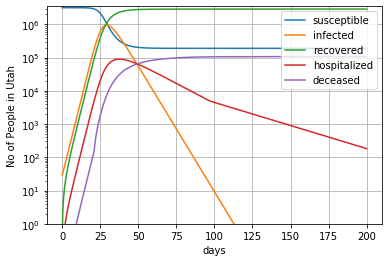

In [5]:
df1=simulate(N=3.2e6,Io=29,steps=40000,tstep=0.005,transitions={'Day0,RO4':[0,3]},
            beta=0.33,gamma_h=0.012,gamma_r=0.2,delta_r=0.02,delta_d=0.012)
covidplt(df1,withdata=False)

In [6]:
df1.iloc[df1.index.get_loc(200,method='nearest')]

S    1.908670e+05
I    2.543384e-07
R    2.899185e+06
H    1.832990e+02
D    1.079168e+05
Name: 199.9999999998906, dtype: float64

**No. of People dead: 108,000: 4% death rate**  <br>
**Almost 3 million people infected**

## Scenario 2: Current Efforts that are Prolonged with Significant Economic Injury

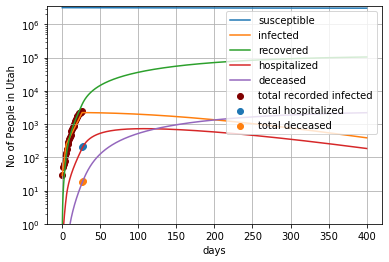

In [7]:
df2=simulate(N=3.2e6,Io=29,steps=80000,tstep=0.005,transitions={'Day0,RO4':[0,3],'Day5,RO2':[5,1.5],'Day26,RO1':[26,1]},
            beta=0.33,gamma_h=0.012,gamma_r=0.2,delta_r=0.02,delta_d=0.012)
covidplt(df2)

In [8]:
df2.iloc[df2.index.get_loc(400,method='nearest')]

S    3.092494e+06
I    3.871226e+02
R    1.047583e+05
H    1.846550e+02
D    2.205136e+03
Name: 399.99999999970873, dtype: float64

**No. of People dead: 2200: 2% death rate**  <br>
**105,000 people infected**<br>
**Vaccine developed to prevent further injury after a year**<br>
**Unacceptable economic injury**

In [9]:
df1.iloc[df1.index.get_loc(27,method='nearest')]

S    1.602465e+06
I    8.591001e+05
R    6.991120e+05
H    3.567608e+04
D    3.844260e+03
Name: 26.999999999998913, dtype: float64

Comparing to Scenario 1 at this time (Day 27): **3,800 lives potentially saved from current efforts to date**

## Scenario 3: Most businesses are opened with continued social distancing
Economic activities restored (except for entertainment and no large gatherings) begining May 1, 2020

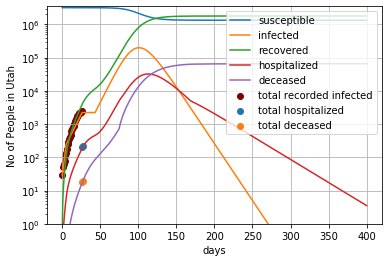

In [10]:
df3=simulate(N=3.2e6,Io=29,steps=80000,tstep=0.005,transitions={'Day0,RO4':[0,3],'Day5,RO2':[5,1.5],'Day26,RO1':[26,1],
                                                               'Day43,RO2':[43,1.5]},
            beta=0.33,gamma_h=0.012,gamma_r=0.2,delta_r=0.02,delta_d=0.012)
covidplt(df3)

In [11]:
df3.iloc[df3.index.get_loc(300,method='nearest')]

S    1.339454e+06
I    9.729049e-02
R    1.794672e+06
H    8.652836e+01
D    6.569370e+04
Name: 299.9999999997997, dtype: float64

**No. of People dead: 65,000: 4% death rate**  <br>
**Over 1.8 million people infected**<br>

Compared to Scenario 1, 43,000 fewer peope die.

## Scenario 4: Most businesses are opened with Stop Gaps
This is scenario 3 but with the option to shut down unnecessary business again, especially when hospitalizations are 25% from the total beds at which point business is halted for another 30 days. Followed by opening most businesses again. The RO rate or the number of people that each infected person infects switches for each case from low to moderate, respectively.

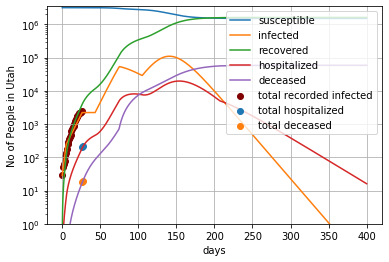

In [12]:
df4=simulate(N=3.2e6,Io=29,steps=80000,tstep=0.005,transitions={'Day0,RO4':[0,3],'Day5,RO2':[5,1.5],'Day26,RO1':[26,1],
                                                               'Day27,RO2':[43,1.5],'D':[75,1],'D2':[105,1.5]},
            beta=0.33,gamma_h=0.012,gamma_r=0.2,delta_r=0.02,delta_d=0.012)
covidplt(df4)

In [13]:
df4.iloc[df4.index.get_loc(400,method='nearest')]

S    1.518647e+06
I    5.061737e-02
R    1.622326e+06
H    1.607715e+01
D    5.898424e+04
Name: 399.99999999970873, dtype: float64

**No. of People dead: 59,000: 4% death rate**  <br>
**Over 1.6 million people infected**<br>

Stopping and starting the economy would not be received favorably.

## Scenario 5: Unnecessary businesses stay closed until June 1, 2020 

This is the same scenario as Scenario 3 with another month of closed businesses.

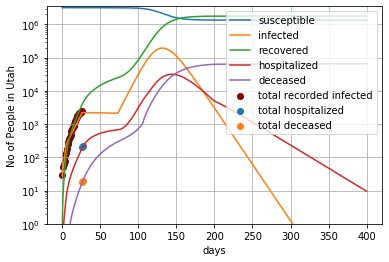

In [14]:
df5=simulate(N=3.2e6,Io=29,steps=80000,tstep=0.005,transitions={'Day0,RO4':[0,3],'Day5,RO2':[5,1.5],'Day26,RO1':[26,1],
                                                               'Day43,RO2':[73,1.5]},
            beta=0.33,gamma_h=0.012,gamma_r=0.2,delta_r=0.02,delta_d=0.012)
covidplt(df5)

In [15]:
df5.iloc[df5.index.get_loc(300,method='nearest')]

S    1.347243e+06
I    1.244981e+00
R    1.787272e+06
H    2.338422e+02
D    6.516112e+04
Name: 299.9999999997997, dtype: float64

**No. of People dead: 65,000: 4% death rate**  <br>
**Over 1.8 million people infected**<br>

Compared with Scenario 3, another months worth of businesses staying closed resulted in 500 lives saved.